In [1]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
from matplotlib import pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix
from scipy.optimize import minimize
from scipy.fftpack import dct, idct
from arch.univariate import *
from pandas_datareader import data as pdr
import yfinance as yf
import warnings
import joblib
from IPython.display import Latex, display
plt.style.use('seaborn-whitegrid')
warnings.filterwarnings('ignore')

In [2]:
## define the date period
train_begin = '2020-10-15'
train_end = '2021-03-26'

In [3]:
cloud_file_list = [i.split('.')[0] for i in os.listdir('cloud_data') if i!='.DS_Store']
crypto_file_list = [i.split('.')[0] for i in os.listdir('crypto_data') if i!='.DS_Store']

In [4]:
## read files
for file in crypto_file_list:
    tmp = pd.read_csv('crypto_data/'+file+'.csv', parse_dates=['snapped_at'], 
                      infer_datetime_format=True).rename(columns={'snapped_at':'Date'})
    tmp = tmp[tmp['Date']>=train_begin].reset_index(drop=True)
    globals()[file] = tmp

for file in cloud_file_list:
    tmp = pd.read_csv('cloud_data/'+file+'.csv', 
                      parse_dates=['Date']).rename(columns={'Close':'price'})
    tmp = tmp[tmp['Date']>=train_begin].reset_index(drop=True)
    globals()[file] = tmp

In [5]:
## fill data on weekends
def fill_weekends(data, col='price'):
    data = filecoin[['Date']].merge(data, how='left')
    data['fill'] = data[col].fillna(method='ffill', limit=1)
    data['fill'] = data['fill'].fillna(method='bfill')
    data['ffill'] = data[col].fillna(method='ffill')
    data['bfill'] = data[col].fillna(method='bfill')
    data['interval'] = (data['ffill']+data['bfill']-2*data['fill'])/3
    data.loc[data[col].isna(), col] = data['fill']+data['interval']
    return data.drop(columns=['fill','ffill','bfill','interval'])

## get daily return
def get_return(data):
    data['return'] = (data['price']-data['price'].shift(1))/data['price'].shift(1)
    return data

## Normalization
def MaxMinScalar(data, col='price'):
    Max = data[col].max()
    Min = data[col].min()
    data[col] = (data[col]-Min)/(Max-Min)
    return data


for file in cloud_file_list:
    globals()[file] = fill_weekends(globals()[file])
    
for file in crypto_file_list+cloud_file_list:
    globals()[file] = get_return(globals()[file])
    globals()[file] = MaxMinScalar(globals()[file])

In [6]:
## GridSearchCV to find optimal parameters
def gridCV(estimator, params, xtrain, ytrain):
    gcv = GridSearchCV( estimator, params ).fit(xtrain, ytrain)
    clf = gcv.best_estimator_
    return clf, gcv.best_params_

## Filecoin Time series analysis

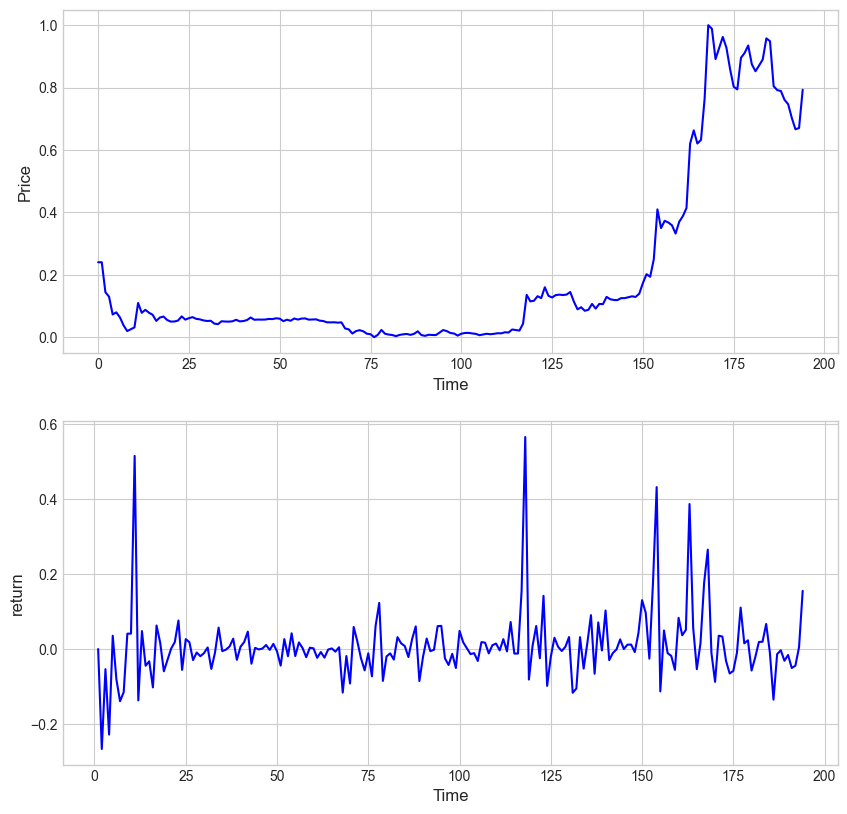

In [7]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,10), dpi=100)
ax1.plot(filecoin['price'], c='blue')
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('Price', fontsize=12)
ax2.plot(filecoin['return'], c='blue')
ax2.set_xlabel('Time', fontsize=12)
ax2.set_ylabel('return', fontsize=12)
plt.savefig('fig/price.png', bbox_inches='tight')

In [8]:
## stationary test
sm.stats.acorr_ljungbox(filecoin['return'].dropna(), lags=[24], return_df=True)

,lb_stat,lb_pvalue
24,13.807095,0.950888


In [9]:
## heteroscedasticity test
filecoin['var'] = filecoin['return'].var()
sm.stats.acorr_ljungbox(filecoin['var'].dropna(), lags=[24], return_df=True)

,lb_stat,lb_pvalue
24,4424.923077,0.0


In [10]:
## descriptive statistics
start_date = '2014-09-17'
end_date = '2021-04-28'
tickers = ['KO','INTC','FB','TSLA']
asset_names = ['Filecoin','Bitcoin','Ethereum','Coca Cola', 'Intel', 'Facebook','Tesla','Bitcoin(init)','Ethereum(init)']
data_list = [filecoin, bitcoin, eth]

for ticker in tickers:
    asset = yf.Ticker(ticker)
    data = asset.history(start='2020-10-15', end='2021-04-27')
    data['return'] = (data['Close']-data['Close'].shift(1))/data['Close'].shift(1)
    data_list.append(data)

for ticker in ['BTC-USD','ETH-USD']:
    asset = yf.Ticker(ticker)
    data = asset.history(start='1900-01-01')
    data = data.iloc[:filecoin.shape[0]]
    data['return'] = (data['Close']-data['Close'].shift(1))/data['Close'].shift(1)
    data_list.append(data)

result = pd.DataFrame({})
for tmp in data_list:
    ds = tmp[['return']].agg(['mean','std','skew','kurt']).T
    ds['jarque_bera'] = str( sm.stats.jarque_bera(tmp['return'].dropna())[:2] )
    if result.shape[0] == 0:
        result = ds
    else:
        result = pd.concat([result, ds])
result.index = asset_names
result

,mean,std,skew,kurt,jarque_bera
Filecoin,0.008574,0.092876,2.685903,13.821350,"(1689.1071360125454, 0.0)"
Bitcoin,0.008876,0.041542,0.419552,2.103159,"(38.540276554284794, 4.276468532625141e-09)"
Ethereum,0.011172,0.052039,0.098658,2.351666,"(41.62270448968939, 9.156817511692243e-10)"
Coca Cola,0.000718,0.012598,0.316820,4.643460,"(109.81823968999535, 1.4232206785202966e-24)"
Intel,0.001134,0.025583,-0.783639,3.016868,"(58.150194497327085, 2.359639752780966e-13)"
Facebook,0.001060,0.021819,0.165347,1.197885,"(7.338489028235792, 0.02549572433234404)"
Tesla,0.004396,0.041285,0.782308,2.690799,"(48.77798535753694, 2.5585567862895614e-11)"
Bitcoin(init),-0.002225,0.042920,-0.378799,5.099253,"(201.67099061858258, 1.6132467809449803e-44)"
Ethereum(init),0.008821,0.110756,-0.239100,13.571353,"(1408.835129536393, 1.1894293900696861e-306)"


## EGarch

In [11]:
mean_model = ZeroMean(filecoin['return'].dropna())
mean_model.volatility = EGARCH(o=1)
egarch = mean_model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 5258096.274986971
Iteration:      2,   Func. Count:     14,   Neg. LLF: 107719268.70428014
Iteration:      3,   Func. Count:     22,   Neg. LLF: 10936412.609071042
Iteration:      4,   Func. Count:     30,   Neg. LLF: -205.67025394583266
Iteration:      5,   Func. Count:     37,   Neg. LLF: -223.9700389402364
Iteration:      6,   Func. Count:     42,   Neg. LLF: -224.03951828237325
Iteration:      7,   Func. Count:     47,   Neg. LLF: -224.04703256851113
Iteration:      8,   Func. Count:     52,   Neg. LLF: -224.04793188773561
Iteration:      9,   Func. Count:     57,   Neg. LLF: -224.0482124202988
Iteration:     10,   Func. Count:     62,   Neg. LLF: -224.04849781495778
Iteration:     11,   Func. Count:     67,   Neg. LLF: -224.04855356193352
Iteration:     12,   Func. Count:     72,   Neg. LLF: -224.0485805693944
Iteration:     13,   Func. Count:     77,   Neg. LLF: -224.04859715023855
Iteration:     14,   Func. Count:     82,   N

In [12]:
omega, alpha, gamma, beta = egarch.params
alpha_star = omega-alpha*(2/np.pi)**0.5
alpha_star = r'$\alpha_{*}=%.4f$'%alpha_star
theta1 = r'$\theta_1=%.4f$'%gamma
alpha = r'$\alpha=%.4f$'%alpha
beta = r'$\beta=%.4f$'%beta
display( Latex(alpha_star) )
display( Latex(theta1) )
display( Latex(alpha) )
display( Latex(beta) )

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

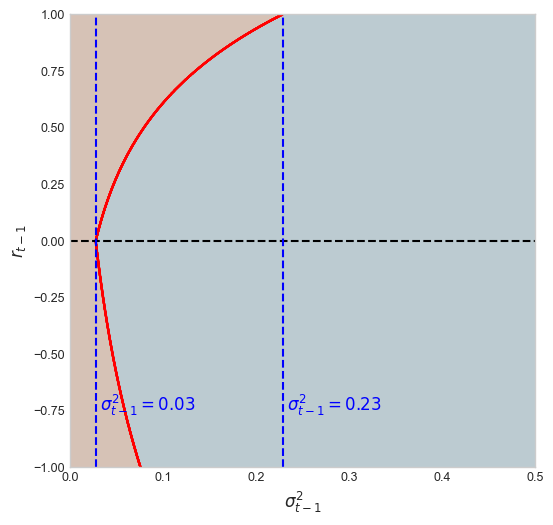

In [13]:
omega, alpha, gamma, beta = egarch.params
alpha_star = omega-alpha*(2/np.pi)**0.5
theta1 = gamma

def vol_analysis(sigma, ret):
    result = []
    for r in ret:
        if r >= 0:
            tmp = sigma**(2*beta-2)*np.exp(alpha_star)*np.exp((theta1+alpha)*r)
            result.append(tmp.tolist())
        else:
            tmp = sigma**(2*beta-2)*np.exp(alpha_star)*np.exp((theta1-alpha)*r)
            result.append(tmp.tolist())
    return np.array(result)
            
sigma = np.linspace(0,0.5,2001)
ret = np.arange(-1000, 1001)/1000
res = vol_analysis(sigma, ret)
res[res>=1] = 1
res[res<1] = 0

X,Y = np.meshgrid(sigma, ret)
fig, ax = plt.subplots(figsize=(6,6), dpi=100)
ax.contour(X,Y,res,colors='red')
ax.contourf(X,Y,res,cmap='twilight')
ax.hlines(xmin=0, xmax=0.5, y=0, ls='--', color='black')
s1 = sigma[ int(res[ret==0].sum()) ]
s2 = sigma[ int(res[ret==1].sum()) ]
ax.vlines(ymin=-1, ymax=1, x=s1, ls='--', color='blue')
ax.vlines(ymin=-1, ymax=1, x=s2, ls='--', color='blue')
ax.text(s1+0.005,-0.75,'$\sigma_{t-1}^2=%.2f$'%s1,c='blue', fontsize=12)
ax.text(s2+0.005,-0.75,'$\sigma_{t-1}^2=%.2f$'%s2,c='blue', fontsize=12)
ax.set_xlabel('$\sigma_{t-1}^2$', fontsize=12)
ax.set_ylabel('$r_{t-1}$', fontsize=12)
ax.tick_params(labelsize=9)
plt.savefig('fig/vol.png', bbox_inches='tight')

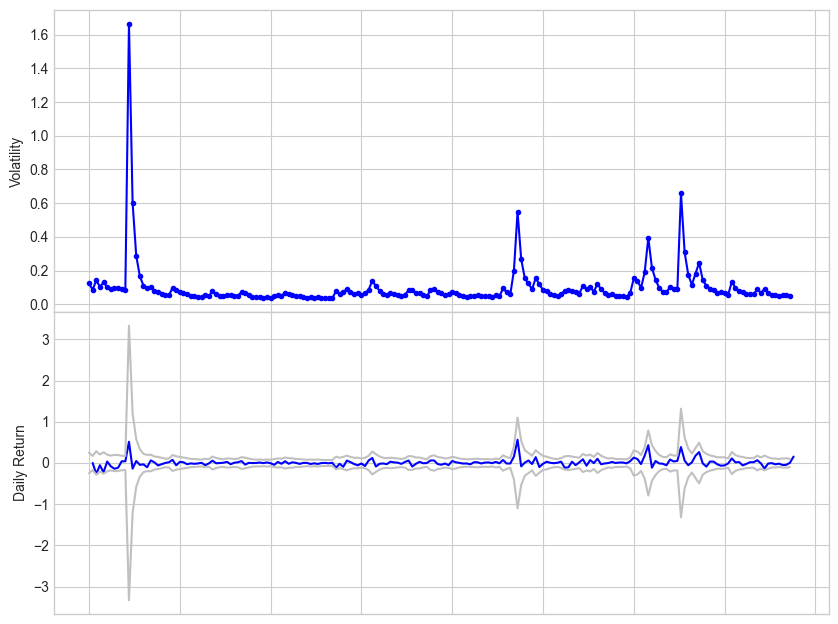

In [14]:
fig = plt.figure(figsize=(10,8), dpi=100)
gs = fig.add_gridspec(2, 1, hspace=0, wspace=0)
ax1, ax2 = gs.subplots(sharex='col')
ax1.plot(egarch._volatility, '.-', c='blue', label='Volatility')
ax2.plot(filecoin['return'], c='blue')
ax2.plot(2*egarch._volatility, c='silver')
ax2.plot(-2*egarch._volatility, c='silver')
ax1.set_ylabel('Volatility')
ax2.set_ylabel('Daily Return')
ax2.set_xticklabels([])
plt.savefig('fig/egarch.png', bbox_inches='tight')

## Build Features

In [15]:
## build features
crypto_file_list.remove('filecoin')
data = pd.DataFrame({'Date':filecoin['Date'],
                     'y':filecoin['return'].shift(-1)}).dropna()
data.loc[data['y']<=0, 'y'] = 0
data.loc[data['y']>0, 'y'] = 1
data['SUDC'] = 0
data['UCOS_lag1'] = 0

## filecoin past up rate
data['FPUR'] = 0
for i in range(1, data.shape[0]):
    data.iloc[i, -1] = data.iloc[:i]['y'].mean()

for file in cloud_file_list:
    tmp = globals()[file]
    tmp.loc[tmp['return']<=0, 'return'] = 0
    tmp.loc[tmp['return']>0, 'return'] = 1
    ## whether up or down on the past day
    data[file+'_UD_lag1'] = tmp['return']
    data[file+'_UC_past5'] = data[file+'_UD_lag1'].rolling(5).sum()
    data['SUDC'] += 1-abs(data['y'].shift(1)-tmp['return'].shift(1))
    data['UCOS_lag1'] += tmp['return']
for file in crypto_file_list:
    tmp = globals()[file]
    tmp.loc[tmp['return']<=0, 'return'] = 0
    tmp.loc[tmp['return']>0, 'return'] = 1
    ## whether up or down on the past day
    data[file+'_UD_lag1'] = tmp['return']
    data[file+'_UC_past5'] = data[file+'_UD_lag1'].rolling(5).sum()
    data['SUDC'] += 1-abs(data['y'].shift(1)-tmp['return'].shift(1))
    data['UCOS_lag1'] += tmp['return']
data = data.dropna()

data['UROS_past5'] = 0
for i in range(1, data.shape[0]):
    for file in cloud_file_list+crypto_file_list:
        data.iloc[i, -1] += data.iloc[i-4:i+1][file+'_UD_lag1'].sum()
    data.iloc[i, -1] /= 75

xtrain = data[data['Date']<=train_end].drop(columns=['Date','y'])
ytrain = data[data['Date']<=train_end]['y']
xtest = data[data['Date']>train_end].drop(columns=['Date','y'])
ytest = data[data['Date']>train_end]['y']

## Model Selection

In [16]:
est_1 = SVC(random_state=0)
param_1 = {'C':np.linspace(0.1,1,9),
           'kernel':['rbf','poly','sigmoid']}

est_2 = RandomForestClassifier(min_samples_leaf=2, random_state=0)
param_2 = {'max_depth':np.arange(2,6),
           'min_samples_split':np.arange(2,10),
           'max_features':['auto', 'sqrt', 'log2']}

est_3 = MLPClassifier(solver='adam',activation='logistic', 
                      learning_rate='adaptive', max_iter=1000, random_state=0)
param_3 = {'hidden_layer_sizes':np.arange(20,101,10)}

In [17]:
clfs = []
hparams = []
for estimator, params in zip([est_1, est_2, est_3], [param_1, param_2, param_3]):
    clf, h = gridCV(estimator, params, xtrain, ytrain)
    clfs.append(clf)
    hparams.append(h)

In [18]:
for clf, model in zip(clfs, ['SVM', 'RandomForest', 'Neural Network']):
    train_acc = clf.score(xtrain, ytrain)
    test_acc = clf.score(xtest, ytest)
    print('%s:\n train accuracy: %6.4f, test accuray: %6.4f'%(model, train_acc, test_acc))

SVM:
 train accuracy: 0.5696, test accuray: 0.5484
RandomForest:
 train accuracy: 0.9114, test accuray: 0.4516
Neural Network:
 train accuracy: 1.0000, test accuray: 0.7419


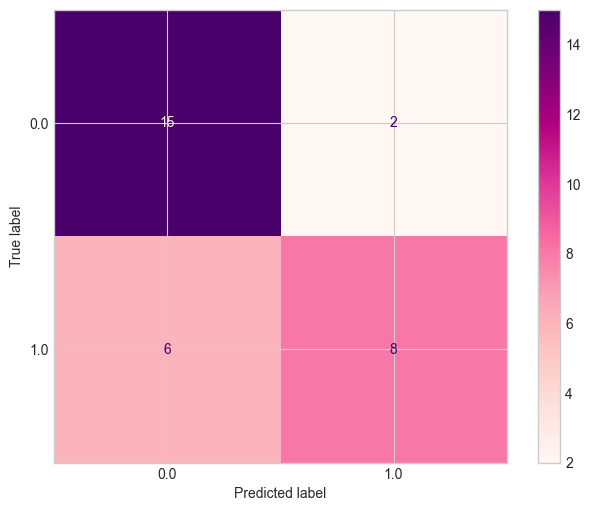

In [19]:
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
plot_confusion_matrix(clfs[-1], xtest, ytest, cmap="RdPu", ax=ax)
plt.savefig('fig/confusion_matrix.png', bbox_inches='tight')

## feature contribution

In [20]:
def category_feature_contribution(model, x, y, features):
    prob_ori = model.predict_proba(x)[:,0]
    
    fig = plt.figure(figsize=(4*3, 5*1.8), dpi=150)
    gs = fig.add_gridspec(5, 3, hspace=0, wspace=0)
    axs = gs.subplots(sharex='col', sharey='row')
    axs = axs.flatten()
    
    print('%15s %15s %15s %15s'%('', 'change 0 to 1', 'change 1 to 0', 'Diff'))
    
    for f,ax in zip(features, axs):
        tmp_x = x.copy()
        tmp_x[f] = np.abs(1-tmp_x[f])
        prob_new = model.predict_proba(tmp_x)[:,0]
        res = pd.DataFrame({'x':x[f], 'prob_change':prob_new-prob_ori})
        res0 = res[res['x']==0]
        res1 = res[res['x']==1]
        
        ax.scatter(res0.index, res0['prob_change'], c='blue', s=6)
        ax.scatter(res1.index, res1['prob_change'], c='red', s=6)
        ax.set_title(f, y=0.82, fontsize=10)
        ax.set_xticklabels([])
        
        print('%15s %15.4f %15.4f %15.4f'%(f, res0['prob_change'].mean(), res1['prob_change'].mean(), 
                                           abs(res0['prob_change'].mean()-res1['prob_change'].mean())))
        
    plt.savefig('fig/category_feature_contribution.png', bbox_inches='tight')
    
    
def numerical_feature_contribution(model, x, y, features):
    prob_ori = model.predict_proba(x)[:,0]
    
    fig = plt.figure(figsize=(12, 9), dpi=150)
    grid = plt.GridSpec(20, 4, hspace=0.3, wspace=0.2)
    ax_left = []
    for i in range(5):
        for j in range(3):
            tmp_ax = fig.add_subplot(grid[4*i:4*(i+1),j])
            tmp_ax.tick_params(labelsize=7)
            ax_left.append( tmp_ax )
    ax_right = []
    for i in range(4):
        tmp_ax = fig.add_subplot(grid[5*i:5*(i+1),-1])
        tmp_ax.tick_params(labelsize=7)
        ax_right.append( tmp_ax )
    
    p, q = 0, 0
    for f in features:
        if f in ['FPUR', 'UROS_past5']:
            unit = 0.01
        else:
            unit = 1
        for i in [-5,-4,-3,-2,-1,1,2,3,4,5]:
            tmp_x = x.copy()
            tmp_x[f] += i*unit
            prob_new = model.predict_proba(tmp_x)[:,0]
            mean_change = (prob_new-prob_ori).mean()
            
            if f not in ['SUDC','UCOS_lag1','FPUR','UROS_past5']:
                if i < 0:
                    ax_left[p].bar(i, mean_change, color='blue', width=0.6)
                else:
                    ax_left[p].bar(i, mean_change, color='red', width=0.6)
                label = 0
            else:
                if i < 0:
                    ax_right[q].bar(i, mean_change, color='blue', width=0.6)
                else:
                    ax_right[q].bar(i, mean_change, color='red', width=0.6)
                label = 1
        if label == 0:
            ax_left[p].set_title(f, y=0.9, fontsize=9)
            if p <= 11:
                ax_left[p].set_xticklabels([])
            p += 1
        else:
            ax_right[q].set_title(f, y=0.9, fontsize=9)
            if q <= 2:
                ax_right[q].set_xticklabels([])
            q += 1
    plt.savefig('fig/numerical_feature_contribution.png', bbox_inches='tight')

In [21]:
category_f = ['{}_UD_lag1'.format(file) for file in cloud_file_list+crypto_file_list]
numerical_f = [f for f in xtrain.columns if f not in category_f]

                  change 0 to 1   change 1 to 0            Diff
    MDB_UD_lag1         -0.0865          0.1046          0.1911
    BOX_UD_lag1          0.0476         -0.0945          0.1421
    DBX_UD_lag1          0.0777         -0.0751          0.1528
   ORCL_UD_lag1          0.0147         -0.0282          0.0430
   AMZN_UD_lag1         -0.0216          0.0016          0.0232
   MSFT_UD_lag1         -0.0524          0.0354          0.0878
    IBM_UD_lag1         -0.0012         -0.0022          0.0010
    VMW_UD_lag1          0.0518         -0.0746          0.1263
   GOOG_UD_lag1         -0.0733          0.0617          0.1351
   BABA_UD_lag1          0.0055          0.0025          0.0030
   usdt_UD_lag1         -0.0384          0.0288          0.0672
    eth_UD_lag1          0.0497         -0.0541          0.1038
bitcoin_UD_lag1          0.0550         -0.0612          0.1162
    ltc_UD_lag1         -0.1223          0.1344          0.2567
   doge_UD_lag1          0.0210         

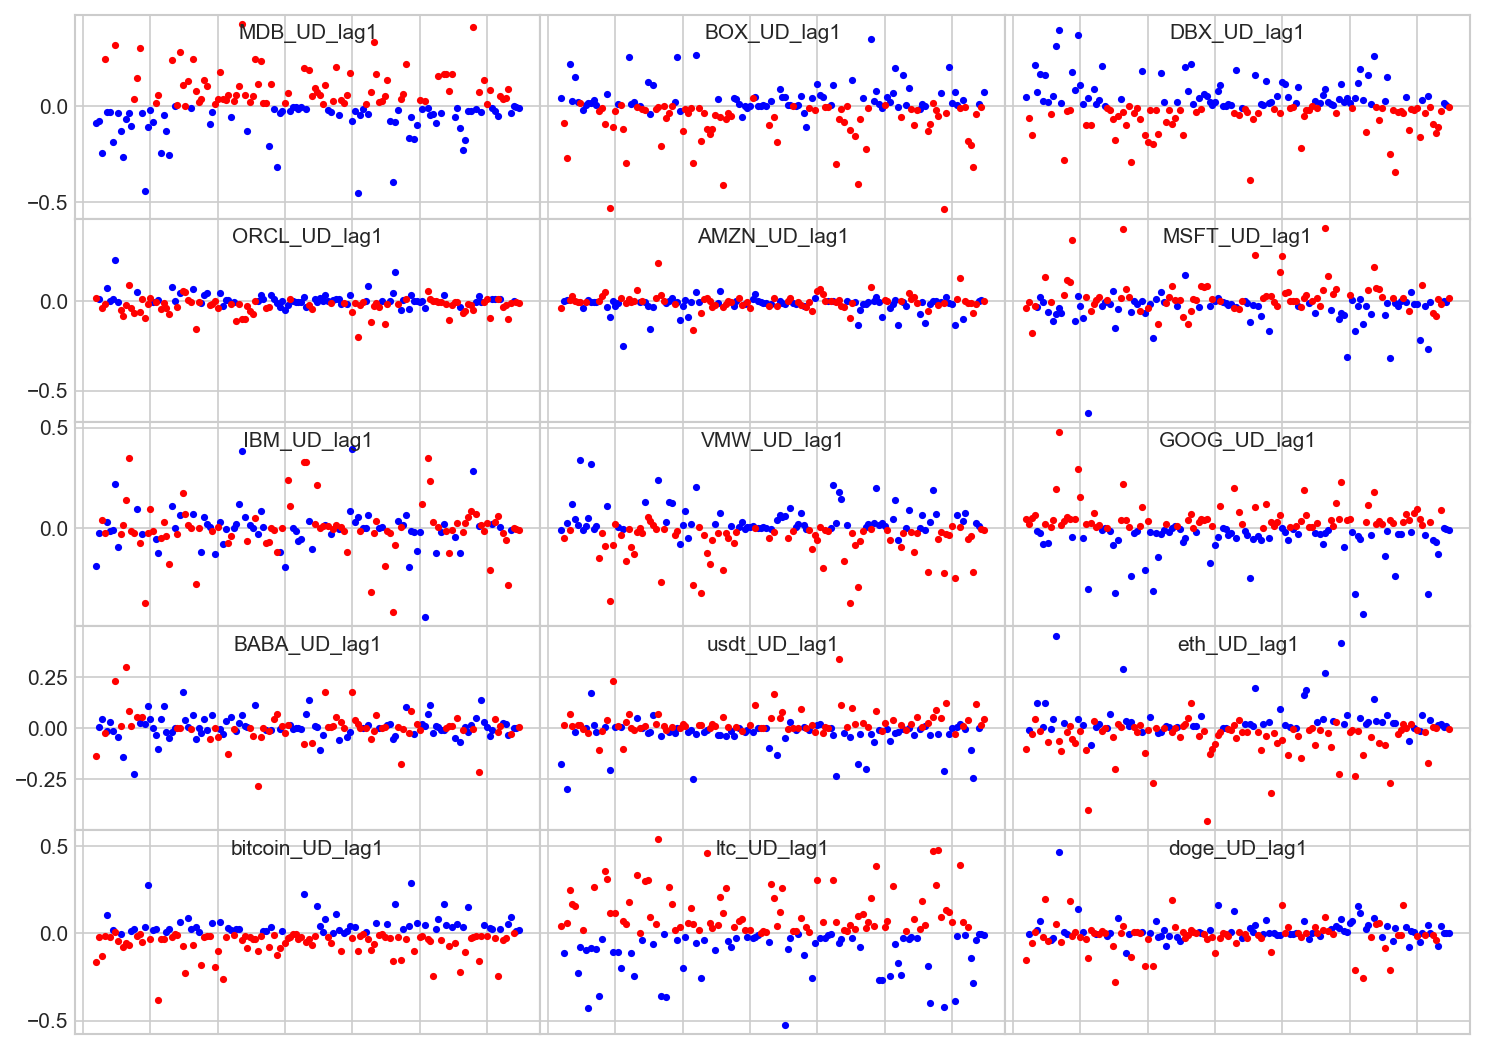

In [22]:
category_feature_contribution(clfs[-1], xtrain, ytrain, category_f)

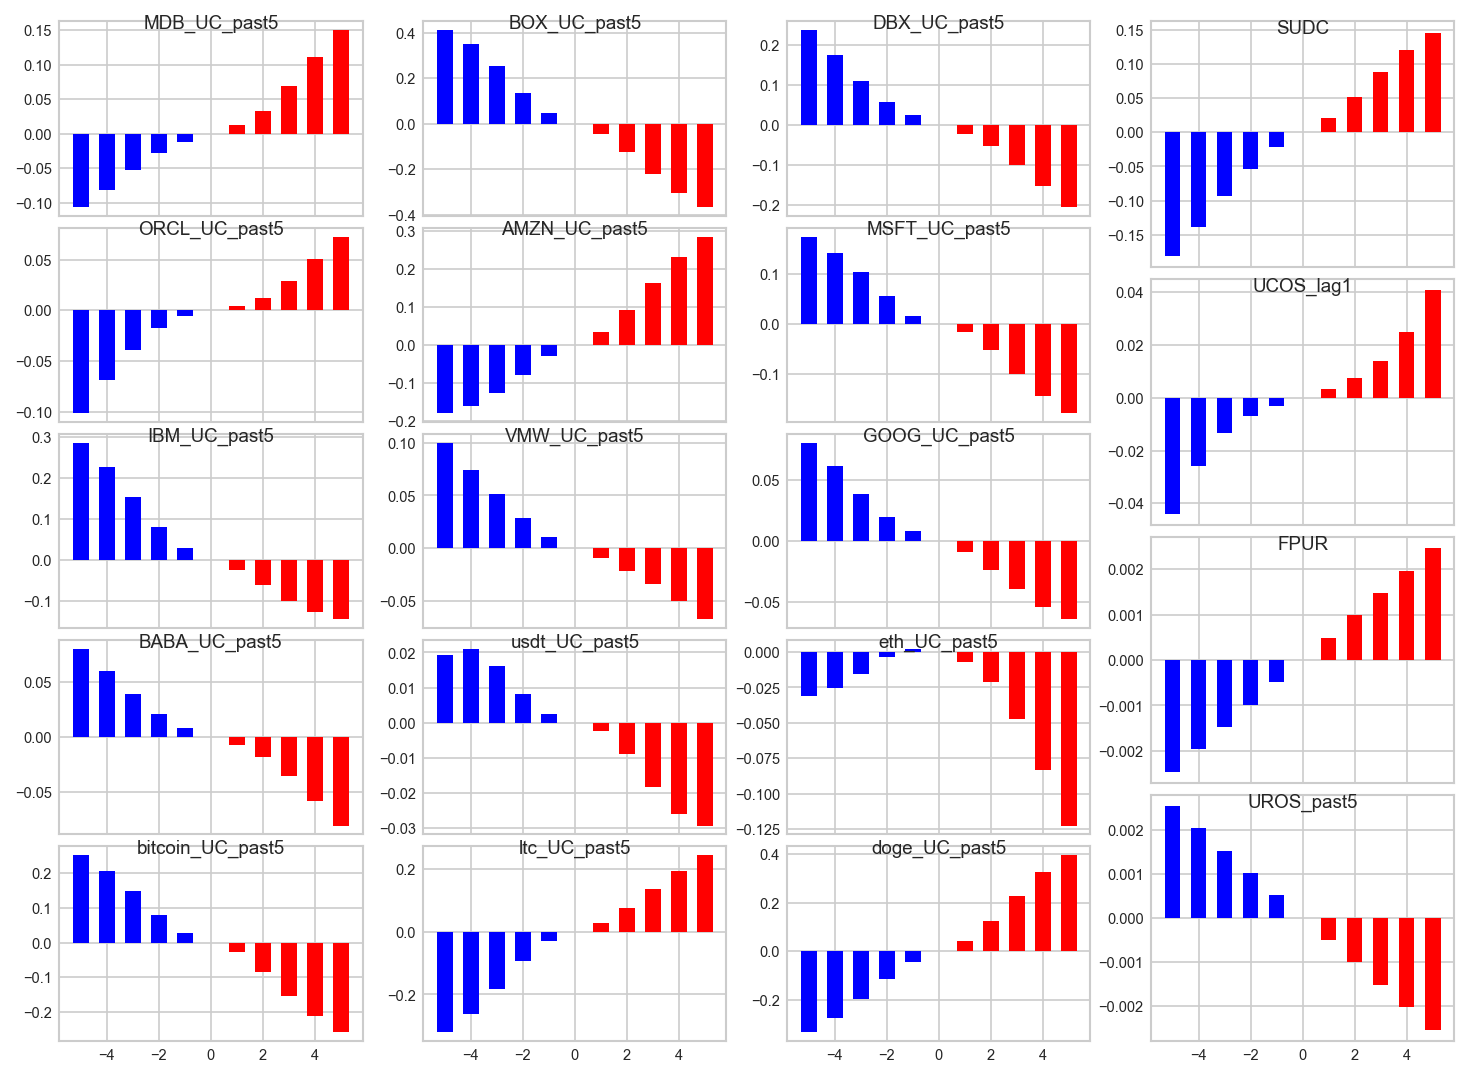

In [23]:
numerical_feature_contribution(clfs[-1], xtrain, ytrain, numerical_f)

In [25]:
## export model and xtest for backtesting
joblib.dump(clfs[-1], 'backtest/clf.m')
xtest.to_csv('backtest/xtest.csv', index=False)